In [ ]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
!pip install pmdarima
import statsmodels.api as sm
from pmdarima.arima import auto_arima
import warnings
warnings.filterwarnings("ignore")

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
sales_data = pd.read_excel("../input/sales-data/sales_data.xlsx")
sales_data.head()

,transaction id,product id,product description,quantity sold,transaction timestamp,unit price,customer id,transaction country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
date = pd.read_excel("../input/sales-data/date.xlsx")
date.head()

,timestamp,date,day_name,day_of_month,month_of_year,time_of_day(hh:mm:ss)
0,2010-12-01 08:26:00,2010-12-01,Wednesday,1,December,08:26:00
1,2010-12-01 08:26:00,2010-12-01,Wednesday,1,December,08:26:00
2,2010-12-01 08:26:00,2010-12-01,Wednesday,1,December,08:26:00
3,2010-12-01 08:26:00,2010-12-01,Wednesday,1,December,08:26:00
4,2010-12-01 08:26:00,2010-12-01,Wednesday,1,December,08:26:00


In [4]:
sales_data.shape, date.shape

((541909, 8), (541909, 6))

In [5]:
print(len(sales_data["transaction country"].unique()))
sales_data["transaction country"].unique()

38


array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [6]:
len(sales_data["product description"].unique())

4224

In [7]:
df = [sales_data, date]
sales = pd.concat(df, axis=1, sort=False)
sales.head()

,transaction id,product id,product description,quantity sold,transaction timestamp,unit price,customer id,transaction country,timestamp,date,day_name,day_of_month,month_of_year,time_of_day(hh:mm:ss)
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01 08:26:00,2010-12-01,Wednesday,1,December,08:26:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,2010-12-01,Wednesday,1,December,08:26:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01 08:26:00,2010-12-01,Wednesday,1,December,08:26:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,2010-12-01,Wednesday,1,December,08:26:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,2010-12-01,Wednesday,1,December,08:26:00


**Remove Duplicates:**

In [8]:
print('sales_data duplicated:{}'.format(sales.duplicated().sum()))
sales.drop_duplicates(inplace=True)

sales_data duplicated:5268


In [9]:
print('sales_data duplicated:{}'.format(sales.duplicated().sum()))

sales_data duplicated:0


**Remove the negative quantity sold from sales dataframe:**

In [10]:
sales[sales["quantity sold"]< 0].shape

(10587, 14)

In [11]:
sales.drop(sales[sales["quantity sold"]< 0].index, inplace=True)

In [12]:
sales[sales["quantity sold"]< 0].shape

(0, 14)

**First order and last order date**

In [13]:
print("Starting Date : ", min(sales.date))
print("Ending Date : ", max(sales.date))

Starting Date :  2010-12-01 00:00:00
Ending Date :  2011-12-09 00:00:00


In [14]:
# monthly_sales=df.groupby(["transaction country", "transaction id","customer id"])[
#    "date","unit price","quantity sold"].agg({"date":["min",'max'],"unit price":"mean","quantity sold":"sum"})
    
# monthly_sales.head()

In [15]:
sales.columns

Index(['transaction id', 'product id', 'product description', 'quantity sold',
       'transaction timestamp', 'unit price', 'customer id',
       'transaction country', 'timestamp              ', 'date', 'day_name',
       'day_of_month', 'month_of_year', 'time_of_day(hh:mm:ss)'],
      dtype='object')

**Remove timestamp columns because we are not going to use.**

In [16]:
sales.drop(['timestamp              ', "transaction timestamp", "time_of_day(hh:mm:ss)"], axis=1, inplace=True)

In [17]:
sales.sample(3)

,transaction id,product id,product description,quantity sold,unit price,customer id,transaction country,date,day_name,day_of_month,month_of_year
412453,572289,23272,TREE T-LIGHT HOLDER WILLIE WINKIE,2,1.65,13782.0,United Kingdom,2011-10-23,Sunday,23,October
539895,581449,23083,SET 6 PAPER TABLE LANTERN STARS,2,3.75,12748.0,United Kingdom,2011-12-08,Thursday,8,December
289156,562224,22988,SOLDIERS EGG CUP,144,1.06,17306.0,United Kingdom,2011-08-03,Wednesday,3,August


In [18]:
sales.columns

Index(['transaction id', 'product id', 'product description', 'quantity sold',
       'unit price', 'customer id', 'transaction country', 'date', 'day_name',
       'day_of_month', 'month_of_year'],
      dtype='object')

# Feature creation
**Here we are multiplying the quatity sold and unit price.**

In [19]:
sales["total"] = sales["quantity sold"] * sales["unit price"]
sales.head()

,transaction id,product id,product description,quantity sold,unit price,customer id,transaction country,date,day_name,day_of_month,month_of_year,total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,Wednesday,1,December,15.30
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,Wednesday,1,December,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,Wednesday,1,December,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,Wednesday,1,December,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,Wednesday,1,December,20.34


**Groupby the sales by date with total and the total should be added because it shows the total money made by company in that sale.**

Here I used the resampling because it shows clearly that the total is incresing or decresing.

In [20]:
datewise_total = sales.groupby("date").agg({"total":"sum"})
datewise_total.head(2)

,total
date,
2010-12-01,58776.79
2010-12-02,47629.42


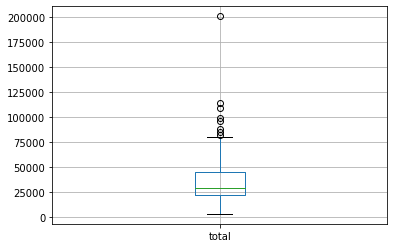

In [21]:
datewise_total.boxplot()

In [22]:
datewise_total = datewise_total.resample("M").sum()
datewise_total.head()

,total
date,
2010-12-31,821452.730
2011-01-31,689811.610
2011-02-28,522545.560
2011-03-31,716215.260
2011-04-30,536968.491


Graph : 

[total = quantity sold * unit price]

date vs total    

**Groupby the sales dataframe by date. Quantity sold should be added because it shows the total product sold in that day. **

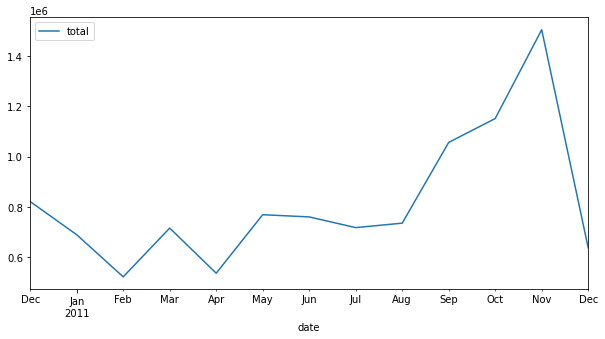

In [23]:
datewise_total.plot(figsize=(10, 5))

In [24]:
# datewise_total = sales.groupby(["date"])["date", "total"].agg("sum")
datewise_total = sales.groupby(["date"])["date", "total"].agg("sum")
datewise_total = datewise_total.resample("M").sum()
#datewise_total["total"].fillna(method="ffill",inplace=True)
datewise_total.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,total
date,
2010-12-31,821452.730
2011-01-31,689811.610
2011-02-28,522545.560
2011-03-31,716215.260
2011-04-30,536968.491


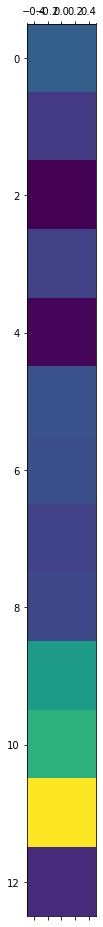

In [25]:
plt.matshow(datewise_total)
plt.show()

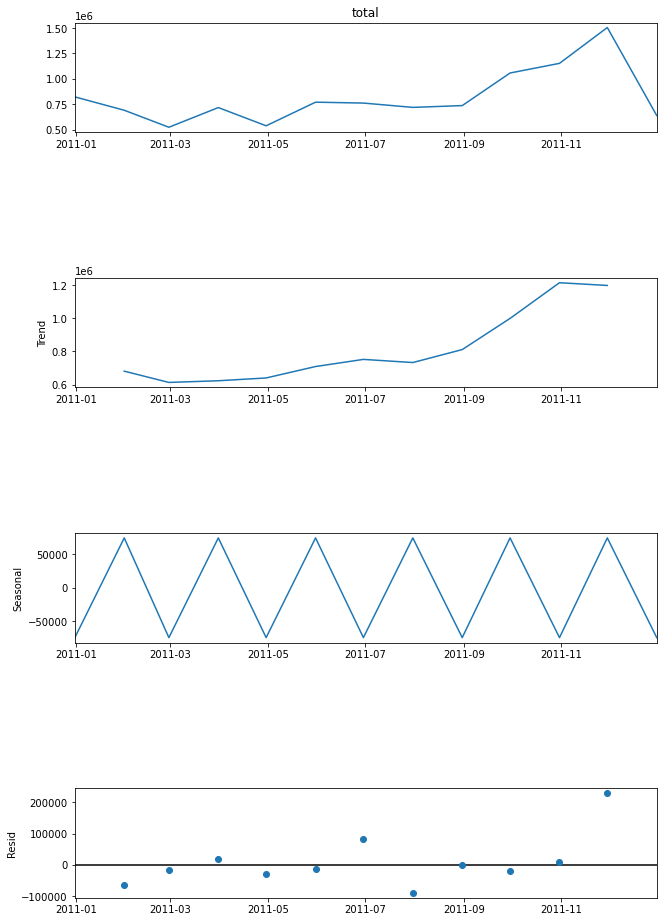

In [26]:
seas_d=sm.tsa.seasonal_decompose(datewise_total['total'],model="additive",period=2)
fig=seas_d.plot()
fig.set_figheight(15)
fig.set_figwidth(10)
plt.show()

In [27]:
datewise_quantity = sales.groupby(["date"]).agg({"quantity sold":"sum"})
datewise_quantity = datewise_quantity.resample("M").sum()
datewise_quantity.head()

,quantity sold
date,
2010-12-31,361094
2011-01-31,397030
2011-02-28,286074
2011-03-31,384023
2011-04-30,311314


In [28]:
datewise_quantity.tail()

,quantity sold
date,
2011-08-31,424266
2011-09-30,574169
2011-10-31,626373
2011-11-30,768468
2011-12-31,314416


Graph :
 
date vs quantity sold

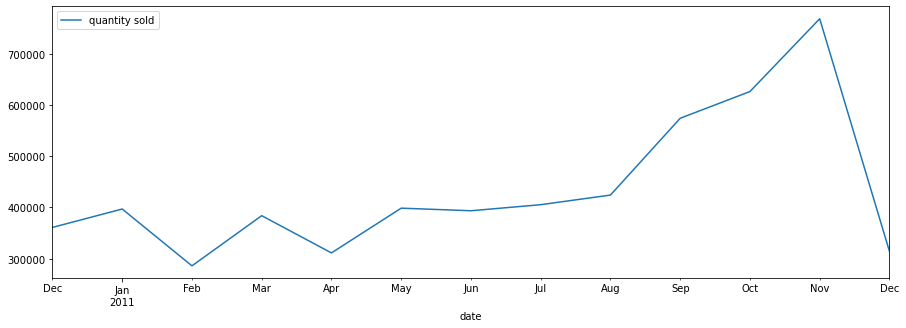

In [29]:
datewise_quantity.plot(figsize=(15,5))

You can conclude from above graph. The max sales is increasing day by day, but it variable. The sales are cleary depend upon the other factors like festivals or something. It dramatically decreasing in the last month i.e. december.

In [30]:
day_total = sales.groupby(["day_name"]).agg({"total":"sum"})
day_total.sort_values("total")

,total
day_name,
Sunday,806790.781
Monday,1775782.071
Friday,1815346.371
Wednesday,1847074.380
Tuesday,2175700.511
Thursday,2199292.570


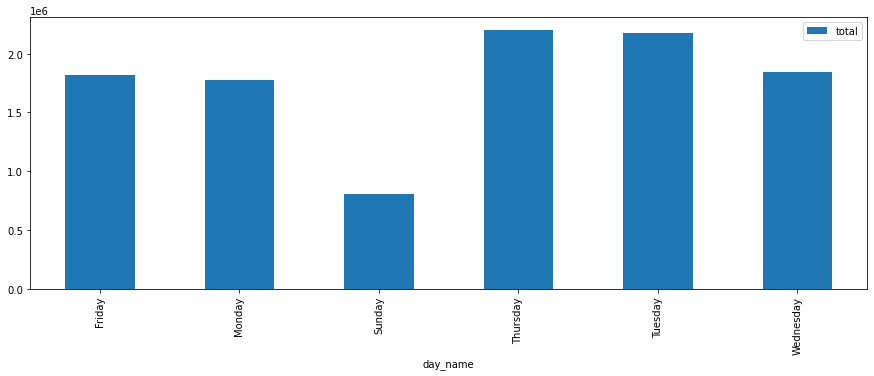

In [31]:
day_total.plot.bar(figsize=(15,5))

From above graph it is clear that the sales are also depend upon the day. If you see at Sunday the sales are cleary low compares to other days.

In [32]:
country_total = sales.groupby("transaction country")["transaction country", "total"].agg("sum")
country_total.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,total
transaction country,
Australia,138453.81
Austria,10198.68
Bahrain,754.14
Belgium,41196.34
Brazil,1143.60


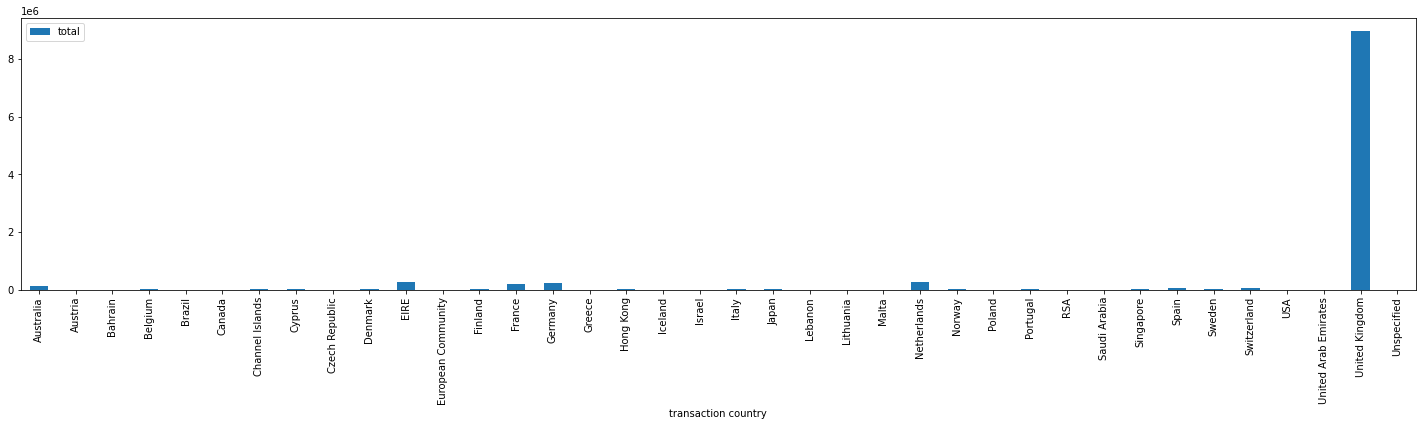

In [33]:
country_total.plot.bar(figsize=(25, 5))

In [34]:
sales.columns

Index(['transaction id', 'product id', 'product description', 'quantity sold',
       'unit price', 'customer id', 'transaction country', 'date', 'day_name',
       'day_of_month', 'month_of_year', 'total'],
      dtype='object')

In [35]:
customer_country = sales.groupby(["transaction country"])["transaction country","customer id"].agg("nunique")
customer_country.drop(["transaction country"], inplace=True, axis=1)
customer_country.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,customer id
transaction country,
Australia,9
Austria,11
Bahrain,2
Belgium,25
Brazil,1


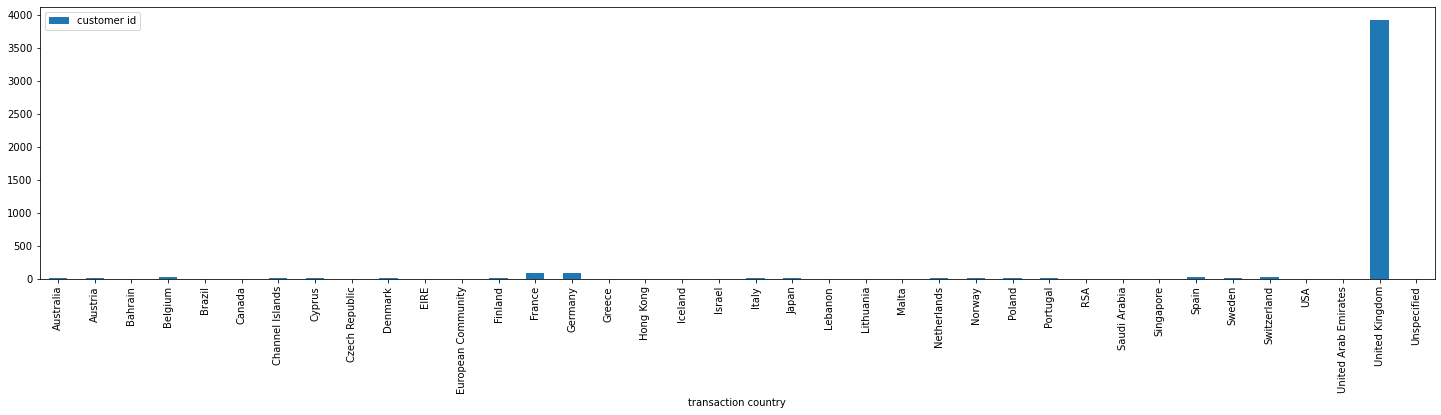

In [36]:
customer_country.plot.bar(figsize=(25, 5))

From above graph it is clear that the much greater number of customers belong to United Kingdom compares
to other countries. 



**Countrywise growth of sales:**



In [37]:
uk_sales = sales[sales["transaction country"]=="United Kingdom"]
uk_sales.head()

,transaction id,product id,product description,quantity sold,unit price,customer id,transaction country,date,day_name,day_of_month,month_of_year,total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,Wednesday,1,December,15.30
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,Wednesday,1,December,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,Wednesday,1,December,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,Wednesday,1,December,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,Wednesday,1,December,20.34


In [38]:
date_total_uk = uk_sales.groupby("date")["date", "total"].agg("sum")
date_total_uk = date_total_uk.resample("M").sum()
date_total_uk.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,total
date,
2010-12-31,746082.220
2011-01-31,559975.830
2011-02-28,428986.620
2011-03-31,584810.780
2011-04-30,475677.631


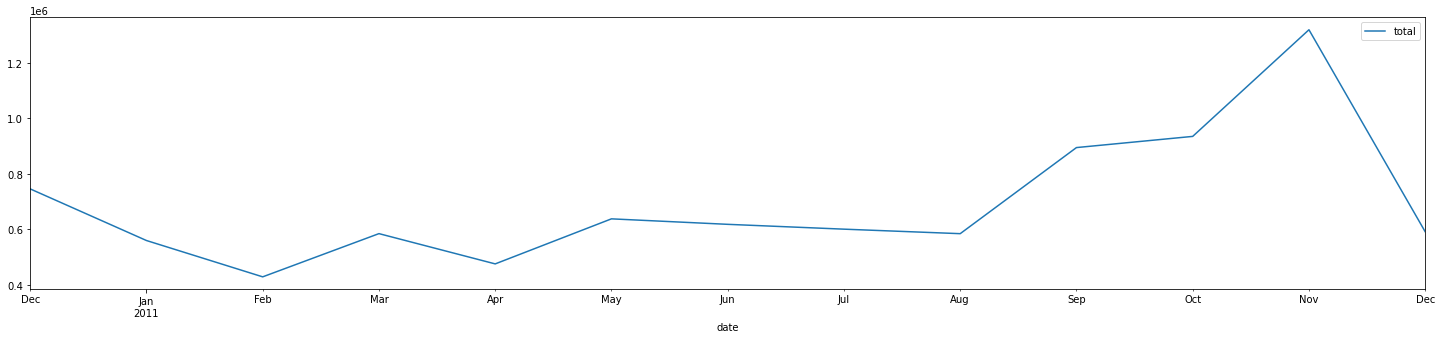

In [39]:
date_total_uk.plot(figsize=(25, 5))

from above graph between the **date vs total** of **uk_sales**
and from the graph between the **date vs total** in **sales** data.
It is clear that **United kingdom** data mostly affects on the total companies data.

clearly the sales max growth is incresing day by day.  

In [40]:
date_customer_uk = (uk_sales.groupby("date")["date", "customer id"].agg("nunique")).drop("date", axis=1)
date_customer_uk.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,customer id
date,
2010-12-01,89
2010-12-02,97
2010-12-03,37
2010-12-05,69
2010-12-06,79


In [41]:
uk_final_sample = date_customer_uk.resample("M").mean()
uk_final_sample.rename(columns={"customer id":"customer count"}, inplace=True)
uk_final_sample["customer count"] = uk_final_sample["customer count"].astype(int)
uk_final_sample.head()

,customer count
date,
2010-12-31,55
2011-01-31,34
2011-02-28,35
2011-03-31,40
2011-04-30,46


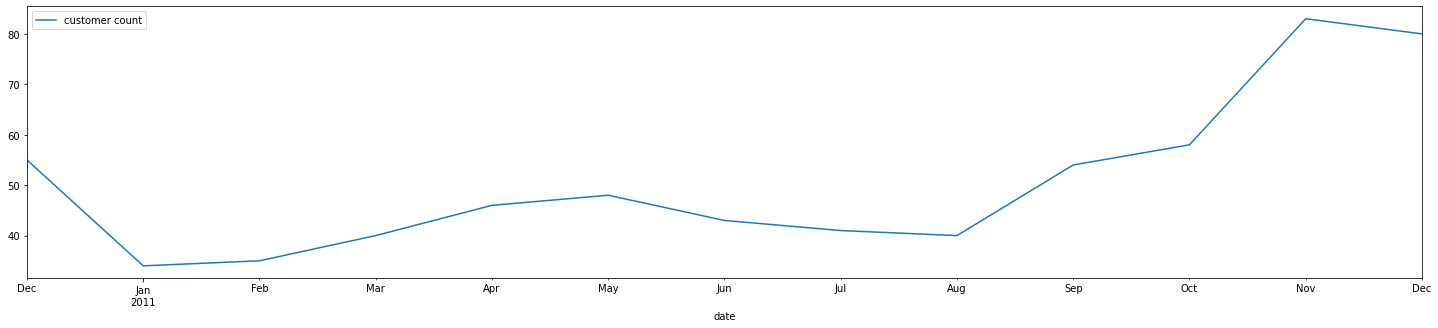

In [42]:
uk_final_sample.plot(figsize=(25, 5))

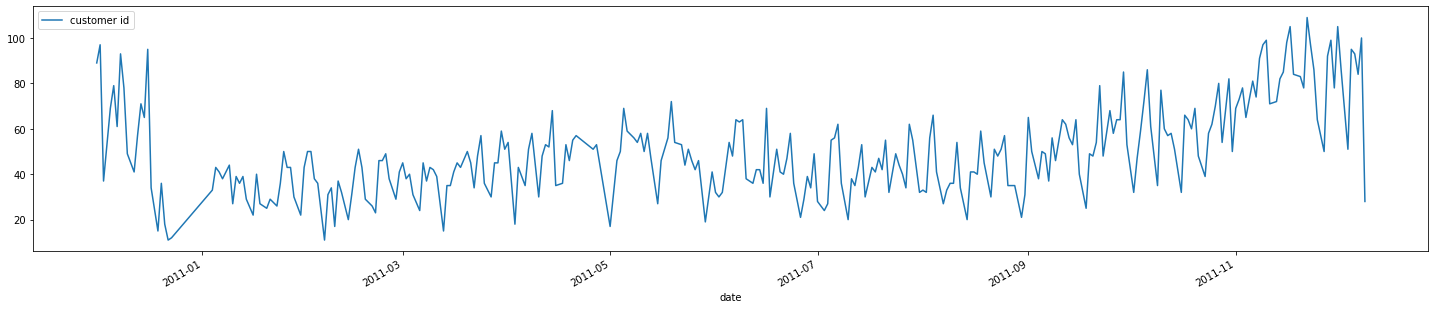

In [43]:
date_customer_uk.plot(figsize=(25, 5))

In [44]:
uk_sales["date"] = pd.to_datetime(uk_sales["date"])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [45]:
# cats = ['Jan', 'Feb', 'Mar', 'Apr','May','Jun', 'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec']
monthly_sales_uk = (uk_sales.groupby(uk_sales["date"].dt.strftime('%B'))["date", "customer id"].agg("nunique").drop("date", axis=1))

# monthly_sales_uk.index = pd.CategoricalIndex(monthly_sales_uk.index, categories=cats, ordered=True)
monthly_sales_uk

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,customer id
date,
April,784
August,834
December,1157
February,679
January,647
July,859
June,889
March,880
May,962


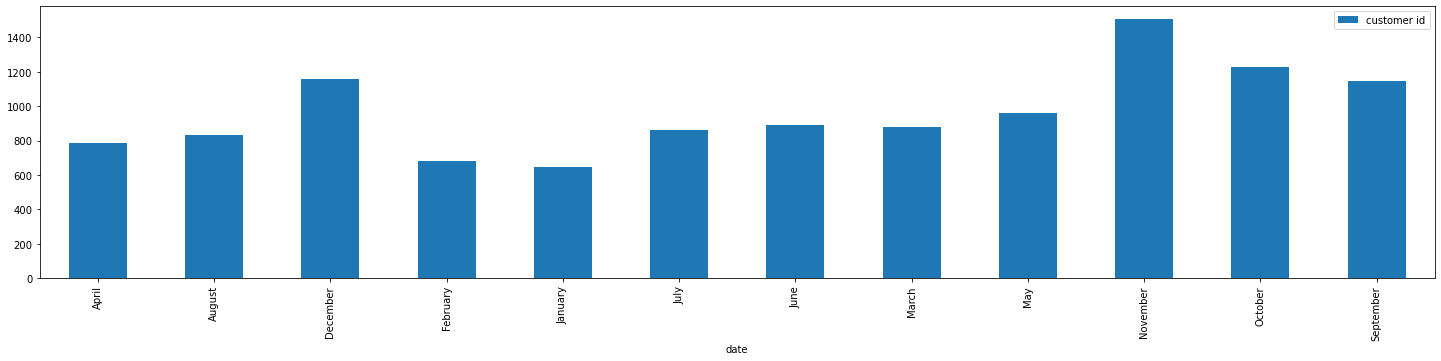

In [46]:
monthly_sales_uk.plot.bar(figsize=(25, 5))

In [47]:
uk_sales.columns

Index(['transaction id', 'product id', 'product description', 'quantity sold',
       'unit price', 'customer id', 'transaction country', 'date', 'day_name',
       'day_of_month', 'month_of_year', 'total'],
      dtype='object')

In [48]:
uk_sales_resample = uk_sales[["date", "customer id", "quantity sold", "unit price", "total"]]

uk_sales_resample.head()


,date,customer id,quantity sold,unit price,total
0,2010-12-01,17850.0,6,2.55,15.30
1,2010-12-01,17850.0,6,3.39,20.34
2,2010-12-01,17850.0,8,2.75,22.00
3,2010-12-01,17850.0,6,3.39,20.34
4,2010-12-01,17850.0,6,3.39,20.34


In [49]:
sales.head()

,transaction id,product id,product description,quantity sold,unit price,customer id,transaction country,date,day_name,day_of_month,month_of_year,total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,Wednesday,1,December,15.30
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,Wednesday,1,December,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,Wednesday,1,December,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,Wednesday,1,December,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,Wednesday,1,December,20.34


In [50]:
sales_group = sales.groupby("customer id").agg({"transaction country":"unique", "total":"sum"}).reset_index()
sales_group["transaction country"] = sales_group["transaction country"].apply(lambda x:x[0])
sales_group.head()

,customer id,transaction country,total
0,12346.0,United Kingdom,77183.60
1,12347.0,Iceland,4310.00
2,12348.0,Finland,1797.24
3,12349.0,Italy,1757.55
4,12350.0,Norway,334.40


In [51]:
country_customer = sales_group.groupby("transaction country").agg({"customer id":"nunique"})
country_customer.sort_values(by="customer id", ascending=False, inplace=True)
country_customer.head()

,customer id
transaction country,
United Kingdom,3921
Germany,94
France,87
Spain,28
Belgium,24


In [52]:
sales.head()

,transaction id,product id,product description,quantity sold,unit price,customer id,transaction country,date,day_name,day_of_month,month_of_year,total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,Wednesday,1,December,15.30
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,Wednesday,1,December,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,Wednesday,1,December,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,Wednesday,1,December,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,Wednesday,1,December,20.34


In [53]:
product_group = sales.groupby("product description").agg({"quantity sold":"sum"})
product_group.sort_values("quantity sold", ascending=False, inplace=True)
product_quantity_sold = product_group.head(20)
product_quantity_sold.head(10)

,quantity sold
product description,
"PAPER CRAFT , LITTLE BIRDIE",80995
MEDIUM CERAMIC TOP STORAGE JAR,78033
WORLD WAR 2 GLIDERS ASSTD DESIGNS,54951
JUMBO BAG RED RETROSPOT,48375
WHITE HANGING HEART T-LIGHT HOLDER,37876
POPCORN HOLDER,36749
PACK OF 72 RETROSPOT CAKE CASES,36396
ASSORTED COLOUR BIRD ORNAMENT,36362
RABBIT NIGHT LIGHT,30739


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text major ticklabel objects>)

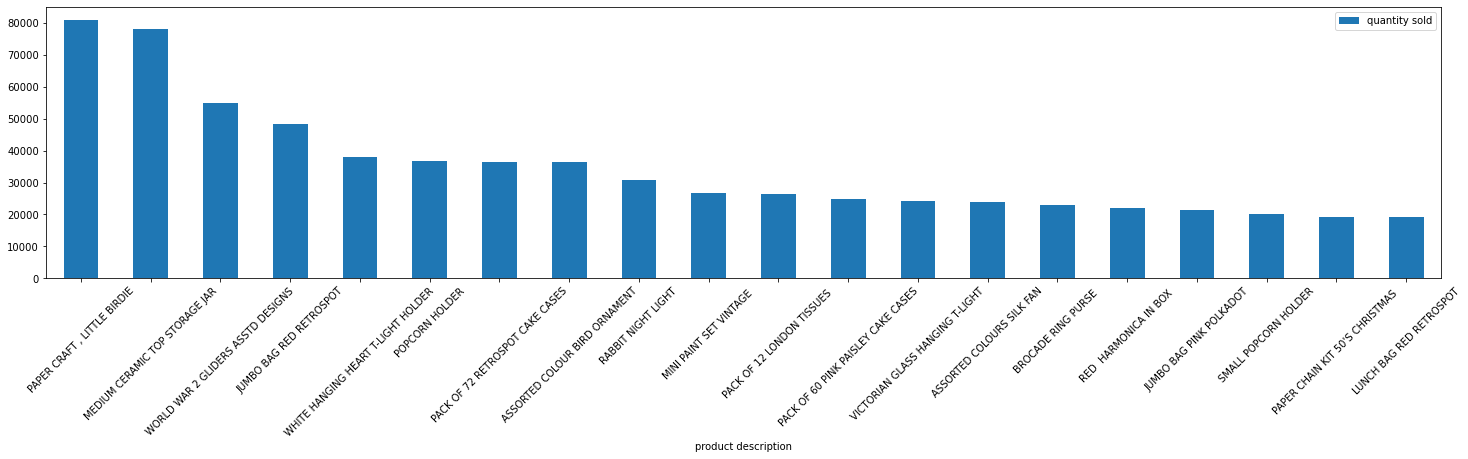

In [54]:
product_quantity_sold.plot.bar(figsize=(25, 5))
plt.xticks(rotation = 45)

From above dataset i.e. **product_quantity_sold** it is clear that mostly decorative products customers are buying. So we can focus on decorative type of product to increase the sales.

Maybe mostly women's are doing shopping on our site. So we can also focus on women's product.
And the sales rate are increasing in last 4 month i.e. Sep, Oct, Nov and Dec.

(array([0]), <a list of 1 Text major ticklabel objects>)

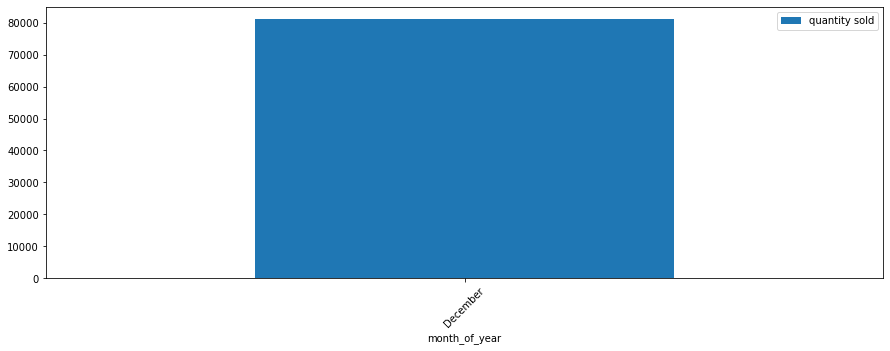

In [55]:
product_1 = sales[sales["product description"]=="PAPER CRAFT , LITTLE BIRDIE"]
product_1_count_date = product_1.groupby("date").agg({"quantity sold":"sum"})
product_1_count_month = product_1.groupby("month_of_year").agg({"quantity sold":"sum"}).sort_values("quantity sold", ascending=False)
product_1_count_month.plot.bar(figsize=(15, 5))
plt.xticks(rotation=45)

,transaction id,product id,product description,quantity sold,unit price,customer id,transaction country,date,day_name,day_of_month,month_of_year,total
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1.04,12346.0,United Kingdom,2011-01-18,Tuesday,18,January,77183.60
186770,552882,23166,MEDIUM CERAMIC TOP STORAGE JAR,96,1.04,14646.0,Netherlands,2011-05-12,Thursday,12,May,99.84
187196,552953,23166,MEDIUM CERAMIC TOP STORAGE JAR,4,1.25,16745.0,United Kingdom,2011-05-12,Thursday,12,May,5.00
187718,553005,23166,MEDIUM CERAMIC TOP STORAGE JAR,5,1.25,14651.0,United Kingdom,2011-05-12,Thursday,12,May,6.25
187868,553009,23166,MEDIUM CERAMIC TOP STORAGE JAR,3,1.25,13601.0,United Kingdom,2011-05-12,Thursday,12,May,3.75


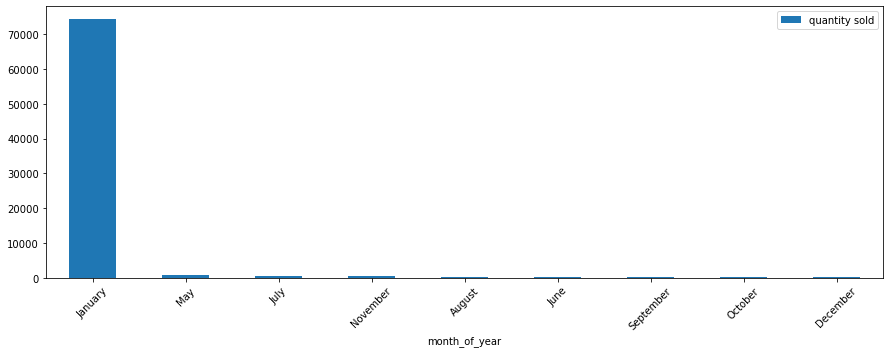

In [56]:
product_2 = sales[sales["product description"]=="MEDIUM CERAMIC TOP STORAGE JAR"]
product_2_count_date = product_2.groupby("date").agg({"quantity sold":"sum"})
product_2_count_month = product_2.groupby("month_of_year").agg({"quantity sold":"sum"}).sort_values("quantity sold", ascending=False)
product_2_count_month.plot.bar(figsize=(15, 5))
plt.xticks(rotation=45)
product_2.head()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

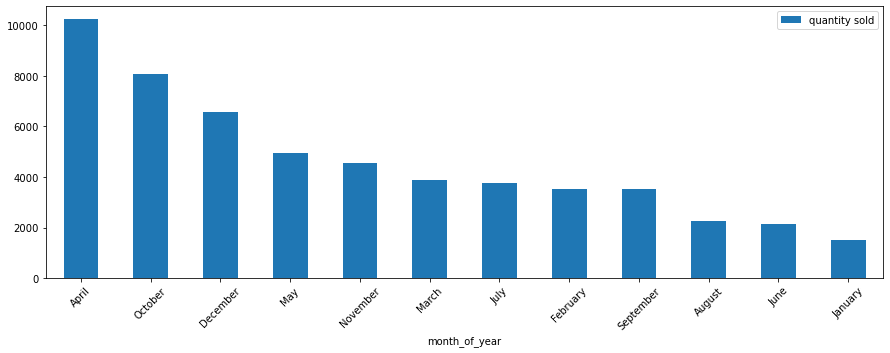

In [57]:
product_3 = sales[sales["product description"]=="WORLD WAR 2 GLIDERS ASSTD DESIGNS"]
product_3_count_date = product_3.groupby("date").agg({"quantity sold":"sum"})
product_3_count_month = product_3.groupby("month_of_year").agg({"quantity sold":"sum"})
product_3_count_month.sort_values("quantity sold", ascending=False, inplace=True)
product_3_count_month.plot.bar(figsize=(15, 5))
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

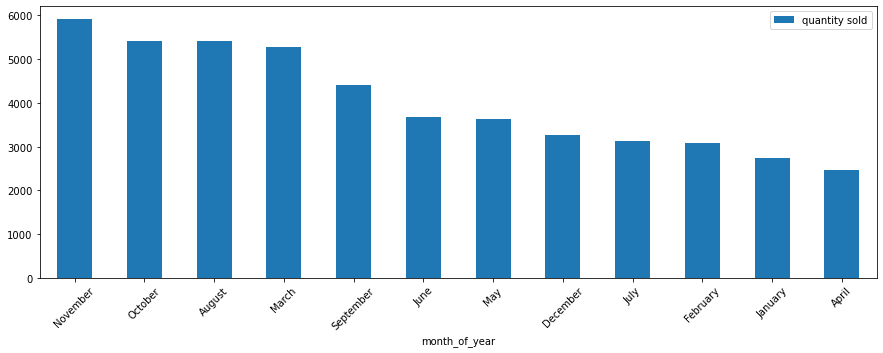

In [58]:
product_3 = sales[sales["product description"]=="JUMBO BAG RED RETROSPOT"]
product_3_count_date = product_3.groupby("date").agg({"quantity sold":"sum"})
product_3_count_month = product_3.groupby("month_of_year").agg({"quantity sold":"sum"}).sort_values("quantity sold", ascending=False)
product_3_count_month.plot.bar(figsize=(15, 5))
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

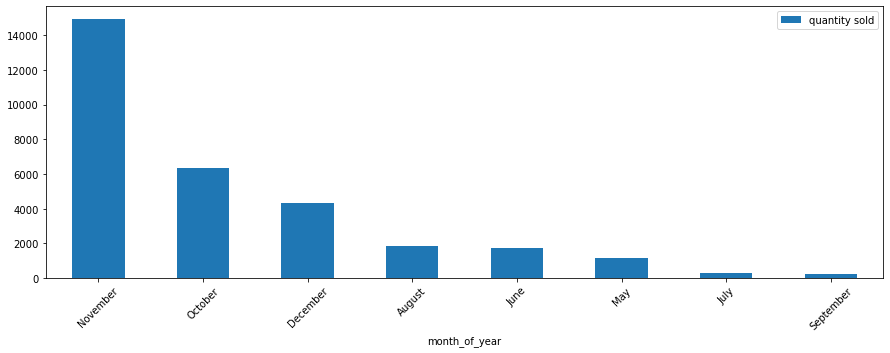

In [59]:

product_3 = sales[sales["product description"]=="RABBIT NIGHT LIGHT"]
product_3_count_date = product_3.groupby("date").agg({"quantity sold":"sum"})
product_3_count_month = product_3.groupby("month_of_year").agg({"quantity sold":"sum"}).sort_values("quantity sold", ascending=False)
product_3_count_month.plot.bar(figsize=(15, 5))
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text major ticklabel objects>)

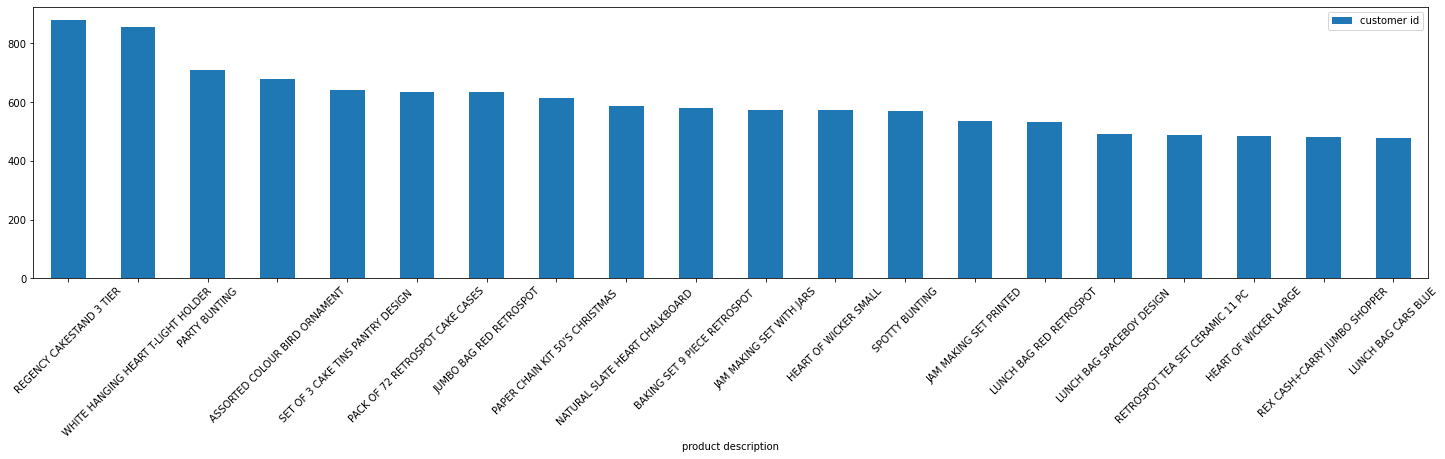

In [60]:
different_customer = sales.groupby("product description").agg({"customer id":"nunique"}).sort_values("customer id", ascending=False).head(20)
different_customer.plot.bar(figsize=(25, 5))
plt.xticks(rotation=45)

**Use of FBProphet**

In [61]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot
from fbprophet.plot import plot_components

In [62]:
datewise_total_reset = sales.groupby("date").agg({"total":"sum"})
datewise_total_reset = datewise_total_reset.reset_index()
datewise_total_reset.rename(columns={"date":"ds", "total":"y"}, inplace=True)
datewise_total_reset.tail()

,ds,y
300,2011-12-05,88620.84
301,2011-12-06,56558.83
302,2011-12-07,75315.55
303,2011-12-08,82371.55
304,2011-12-09,200900.98


In [63]:
datewise_total_reset.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [64]:
test_datewise_total = pd.date_range(start="12/10/2011", end="31/1/2012")
test_datewise_total = pd.DataFrame(test_datewise_total, columns= ["ds"])
test_datewise_total.head()

,ds
0,2011-12-10
1,2011-12-11
2,2011-12-12
3,2011-12-13
4,2011-12-14


In [65]:
fb_model = Prophet()
fb_model.add_seasonality(name="monthly", period=7, fourier_order=5)
fb_model.add_country_holidays(country_name='UK')
fb_model.fit(datewise_total_reset)

In [66]:
fb_model.train_holiday_names

0                             New Year's Day
1                New Year Holiday [Scotland]
2     New Year Holiday [Scotland] (Observed)
3       St. Patrick's Day [Northern Ireland]
4                                Good Friday
5                     Easter Monday [England
6                                      Wales
7                          Northern Ireland]
8                                    May Day
9                        Spring Bank Holiday
10    Battle of the Boyne [Northern Ireland]
11            Summer Bank Holiday [Scotland]
12         Late Summer Bank Holiday [England
13               St. Andrew's Day [Scotland]
14                             Christmas Day
15                  Christmas Day (Observed)
16                                Boxing Day
17                     Boxing Day (Observed)
18                 New Year's Day (Observed)
19          Wedding of William and Catherine
dtype: object

In [68]:
forecast = fb_model.predict(test_datewise_total)
forecast_result = forecast[["ds", "yhat"]]
forecast_result.rename(columns={"ds":"date", "yhat":"total"}, inplace=True)
forecast_result.set_index("date", inplace=True)
forecast_result.head()

,total
date,
2011-12-10,96097.402194
2011-12-11,46401.530094
2011-12-12,68169.804704
2011-12-13,73360.336281
2011-12-14,65975.377034


In [69]:
datewise_total = sales.groupby("date").agg({"total":"sum"})
datewise_total.tail()

,total
date,
2011-12-05,88620.84
2011-12-06,56558.83
2011-12-07,75315.55
2011-12-08,82371.55
2011-12-09,200900.98


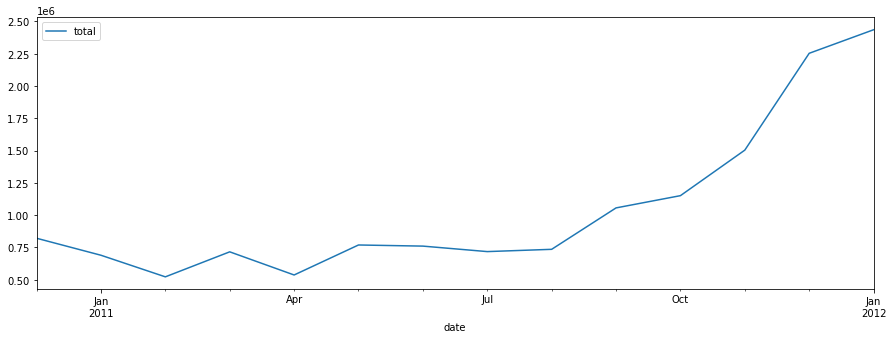

In [70]:
df = pd.concat([datewise_total, forecast_result], axis=0, sort=False)
df = df.resample("M").sum()
df.plot(figsize=(15, 5))

In [71]:
forecast_train = fb_model.predict(datewise_total_reset)
forecast_train.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Battle of the Boyne [Northern Ireland],Battle of the Boyne [Northern Ireland]_lower,Battle of the Boyne [Northern Ireland]_upper,Boxing Day,...,monthly,monthly_lower,monthly_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-12-01,39644.171586,14424.077815,54625.169682,39644.171586,39644.171586,0.0,0.0,0.0,0.0,...,-2734.836595,-2734.836595,-2734.836595,-1609.343393,-1609.343393,-1609.343393,0.0,0.0,0.0,35299.991597
1,2010-12-02,39539.480849,22581.418892,61685.843955,39539.480849,39539.480849,0.0,0.0,0.0,0.0,...,782.283803,782.283803,782.283803,1295.731036,1295.731036,1295.731036,0.0,0.0,0.0,41617.495688
2,2010-12-03,39434.790112,16655.970818,55855.622696,39434.790112,39434.790112,0.0,0.0,0.0,0.0,...,-3191.873970,-3191.873970,-3191.873970,-226.007698,-226.007698,-226.007698,0.0,0.0,0.0,36016.908443
3,2010-12-05,39225.408639,-3377.342868,36201.772942,39225.408639,39225.408639,0.0,0.0,0.0,0.0,...,-15113.543760,-15113.543760,-15113.543760,-7924.522678,-7924.522678,-7924.522678,0.0,0.0,0.0,16187.342200
4,2010-12-06,39120.717902,18879.166662,57697.818419,39120.717902,39120.717902,0.0,0.0,0.0,0.0,...,-200.566335,-200.566335,-200.566335,-1362.545656,-1362.545656,-1362.545656,0.0,0.0,0.0,37557.605911


In [72]:
forecast_result = pd.concat([forecast_train, forecast], axis=0, sort=False)

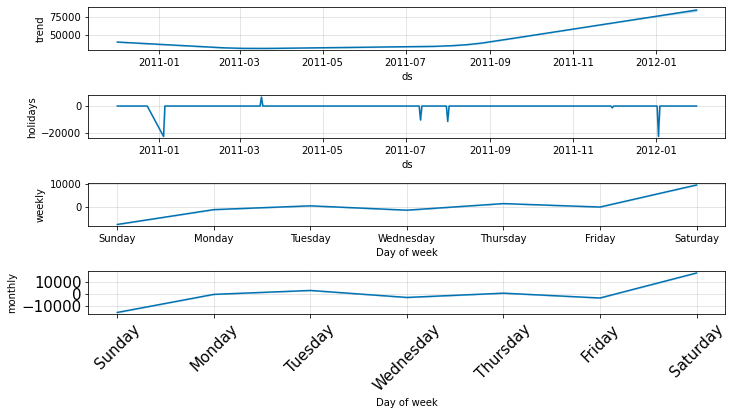

In [73]:
fig = plot_components(fb_model, forecast_result, figsize=(10, 5))
ax = fig.gca()
ax.tick_params(axis="x", labelsize=15, rotation=45)
ax.tick_params(axis="y", labelsize=15)

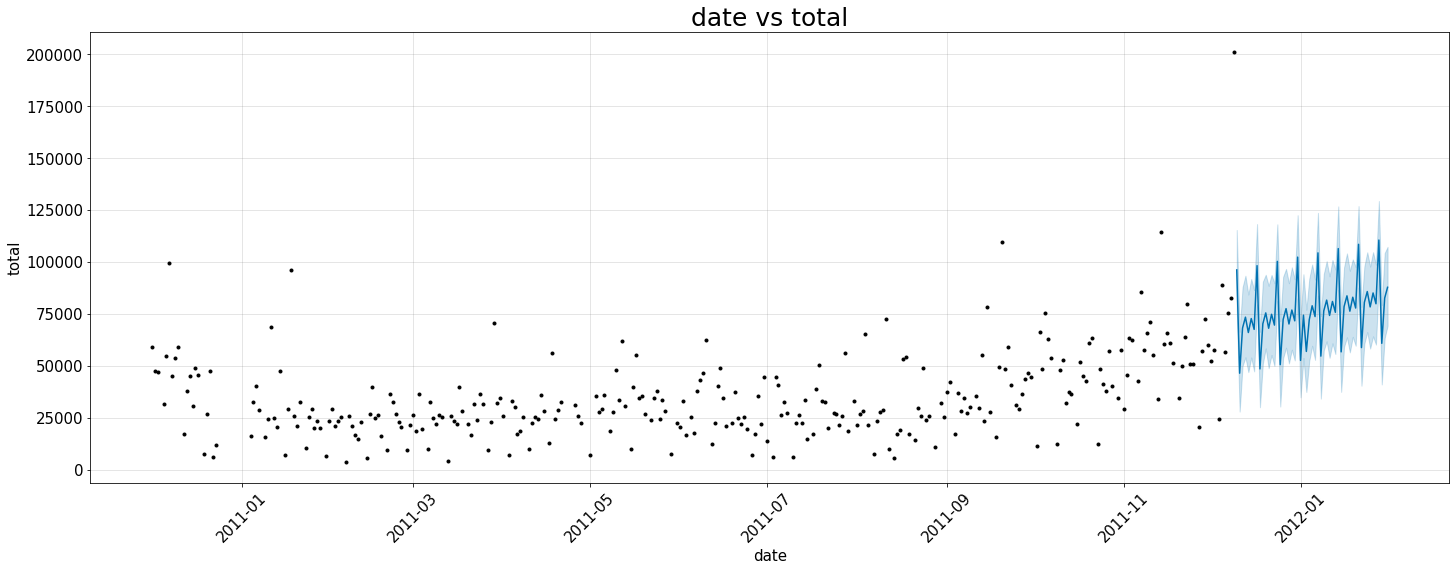

In [74]:
fig = plot(fb_model, forecast, figsize=(20, 7))
ax = fig.gca()
ax.set_title("date vs total", size=25)
ax.set_xlabel("date", size=15)
ax.set_ylabel("total", size=15)
ax.tick_params(axis="x", labelsize=15, rotation=45)
ax.tick_params(axis="y", labelsize=15)

In [75]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Battle of the Boyne [Northern Ireland],Battle of the Boyne [Northern Ireland]_lower,Battle of the Boyne [Northern Ireland]_upper,Boxing Day,...,monthly,monthly_lower,monthly_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-12-10,69146.276369,77419.408970,115318.491052,69146.276369,69146.276369,0.0,0.0,0.0,0.0,...,17431.627387,17431.627387,17431.627387,9519.498438,9519.498438,9519.498438,0.0,0.0,0.0,96097.402194
1,2011-12-11,69439.596532,27912.595416,66322.858840,69439.596532,69439.596532,0.0,0.0,0.0,0.0,...,-15113.543760,-15113.543760,-15113.543760,-7924.522678,-7924.522678,-7924.522678,0.0,0.0,0.0,46401.530094
2,2011-12-12,69732.916695,49867.734783,87710.832305,69732.916695,69732.916695,0.0,0.0,0.0,0.0,...,-200.566335,-200.566335,-200.566335,-1362.545656,-1362.545656,-1362.545656,0.0,0.0,0.0,68169.804704
3,2011-12-13,70026.236859,54059.195709,93316.568460,70020.951729,70028.382496,0.0,0.0,0.0,0.0,...,3026.909471,3026.909471,3026.909471,307.189952,307.189952,307.189952,0.0,0.0,0.0,73360.336281
4,2011-12-14,70319.557022,46915.924032,84249.625969,70306.264740,70326.525915,0.0,0.0,0.0,0.0,...,-2734.836595,-2734.836595,-2734.836595,-1609.343393,-1609.343393,-1609.343393,0.0,0.0,0.0,65975.377034


In [76]:
forecast_yhat = forecast[["ds", "yhat"]]
forecast_yhat.rename(columns={"yhat":"y"}, inplace=True)
forecast_yhat.head()

,ds,y
0,2011-12-10,96097.402194
1,2011-12-11,46401.530094
2,2011-12-12,68169.804704
3,2011-12-13,73360.336281
4,2011-12-14,65975.377034


In [77]:
df = pd.concat([datewise_total_reset, forecast_yhat], axis=0, sort=False)
df.rename(columns={"ds":"date", "y":"total"}, inplace=True)
df.set_index("date", inplace=True)
df.head()

,total
date,
2010-12-01,58776.79
2010-12-02,47629.42
2010-12-03,46898.63
2010-12-05,31364.63
2010-12-06,54624.15


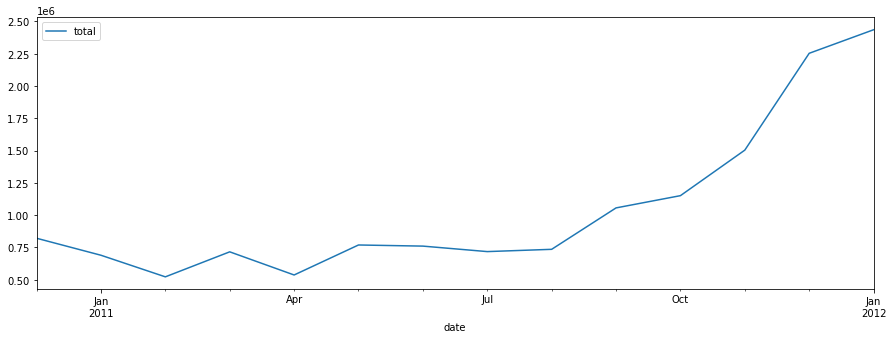

In [78]:
df_resample = df.resample("M").sum()
df_resample.plot(figsize=(15, 5))

**What kind of customer typically buy from us?**

In [79]:
customer_count = sales.groupby("transaction country").agg({"customer id":"nunique"})
customer_count[customer_count.index=="United Kingdom"].values[0][0]

3921

In [80]:
customer_count = sales.groupby("transaction country").agg({"customer id":"nunique"})
print("total customers : ", customer_count["customer id"].sum())
print("total customers in UK : ",customer_count[customer_count.index=="United Kingdom"].values[0][0])

total customers :  4347
total customers in UK :  3921


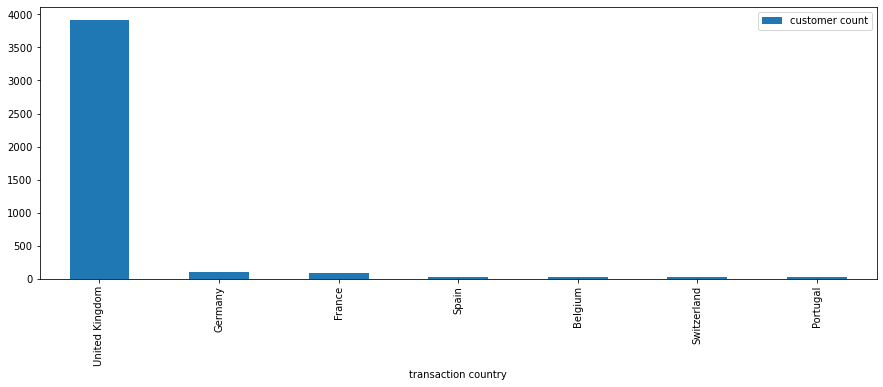

In [81]:
customer_count = sales.groupby("transaction country").agg({"customer id":"nunique"})
customer_count = customer_count.sort_values("customer id", ascending=False).head(7)
customer_count.rename(columns={"customer id":"customer count"}, inplace=True)
customer_count.plot.bar(figsize=(15, 5))

**United Kingdom**

In [82]:
sales_uk = sales[sales["transaction country"]=="United Kingdom"]
product_uk = sales_uk.groupby("product description").agg({"quantity sold":"sum"})
sort_uk_product = product_uk.sort_values("quantity sold", ascending=False).head(10)
sort_uk_product

,quantity sold
product description,
"PAPER CRAFT , LITTLE BIRDIE",80995
MEDIUM CERAMIC TOP STORAGE JAR,77036
WORLD WAR 2 GLIDERS ASSTD DESIGNS,49430
JUMBO BAG RED RETROSPOT,44165
WHITE HANGING HEART T-LIGHT HOLDER,35726
POPCORN HOLDER,34726
ASSORTED COLOUR BIRD ORNAMENT,33636
PACK OF 12 LONDON TISSUES,25315
PACK OF 72 RETROSPOT CAKE CASES,24963


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

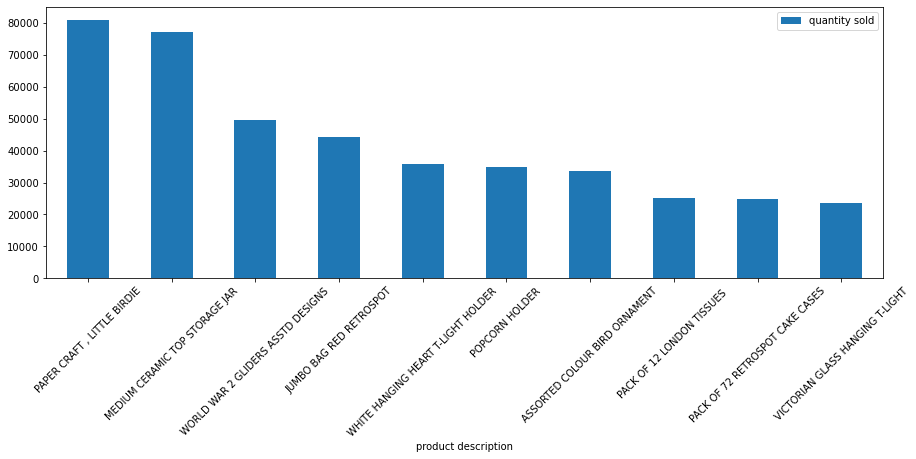

In [83]:
sales_uk = sales[sales["transaction country"]=="United Kingdom"]
product_uk = sales_uk.groupby("product description").agg({"quantity sold":"sum"})
sort_uk_product = product_uk.sort_values("quantity sold", ascending=False).head(10)
sort_uk_product.plot.bar(figsize=(15, 5))
plt.xticks(rotation=45)

**Germany**

In [84]:
sales_ge = sales[sales["transaction country"]=="Germany"]
product_ge = sales_ge.groupby("product description").agg({"quantity sold":"sum"})
product_ge.sort_values("quantity sold", ascending=False).head(10)

,quantity sold
product description,
ROUND SNACK BOXES SET OF4 WOODLAND,1221
ASSORTED COLOURS SILK FAN,1164
POSTAGE,1114
WOODLAND CHARLOTTE BAG,1020
PACK OF 72 RETROSPOT CAKE CASES,1002
PACK OF 6 BIRDY GIFT TAGS,936
SPACEBOY LUNCH BOX,876
PLASTERS IN TIN WOODLAND ANIMALS,856
JAM MAKING SET PRINTED,816


In [85]:
sales.head()

,transaction id,product id,product description,quantity sold,unit price,customer id,transaction country,date,day_name,day_of_month,month_of_year,total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,Wednesday,1,December,15.30
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,Wednesday,1,December,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,Wednesday,1,December,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,Wednesday,1,December,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,Wednesday,1,December,20.34


In [86]:
customer_date = sales.groupby("customer id").agg({"date":"nunique"})
customer_date.rename(columns={"date":"num of times shopping"}, inplace=True)
customer_date.sort_values("num of times shopping", ascending=False).head(10)

,num of times shopping
customer id,
14911.0,132
12748.0,114
17841.0,112
15311.0,90
14606.0,89
12971.0,71
13089.0,66
14527.0,54
13798.0,53
